In [2]:
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import multivariate_normal as mvn
from scipy.stats import norm
import sys
sys.path.insert(0, '../zdrojaky/kf')
from kf import KF
np.set_printoptions(precision=2)


Bad key "xtick.alignment" on line 250 in
/usr/share/matplotlib/mpl-data/stylelib/classic.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution

Bad key "ytick.alignment" on line 268 in
/usr/share/matplotlib/mpl-data/stylelib/classic.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


# Lecture 4: State-space models, Kalman filter

## Motivation example

We observe a vertically thrown object and are interested in its velocity $v_t$ and its "precise" height $h_t$. We call both these variables as the **state variables** or shortly **state**. The index $t=1,2,\ldots$ are discrete time instants (seconds). In addition, we have imprecise - *noisy* - **measurements** of the object height obtained from a sensor. We denote these altitude measurements as $y_{h,t}$. For simplicity, we neglect the aerodynamic drag.

From the physics we know the equations for a decelerated object:

$$
\begin{aligned}
h_t &= h_{0} + v_0 \Delta_t - \frac{1}{2} g \Delta_t^2 + w_{h,t}, \\
v_t &= v_0 - g\Delta_t + w_{v,t},
\end{aligned}
$$

where $g = 9.81ms^{-2}$ is the gravitation constant, $v_0$ is the initial velocity, $y_0$ is the initial height and $\Delta_t = t-t_0$ is the time since $t_0$. Usually $t_0 = 0$, which leads to $\Delta_t = t$. The terms $w_{h,t}$ and $w_{v,t}$ are the state noise variables.

Note that the **state** is ipso facto the model **parameter**, however, it is not constant but has its own model.

Our subject is mostly about sequential (online) modelling. And we want to apply this on the state-space models too. Therefore, we have to modify the equations so that they describe the evolution of state variables from time $t-1$ to $t$. This is quite easy,

$$
\begin{aligned}
h_t &= h_{t-1} + v_{t-1} \Delta_t - \frac{1}{2} g \Delta_t^2,\\
v_t &= v_{t-1} - g \Delta_t.
\end{aligned}
$$

In the matrix notation,

$$
\underbrace{
\begin{bmatrix}
h_t \\
v_t
\end{bmatrix}
}_{x_t}
=
\underbrace{
\begin{bmatrix}
1 & \Delta_t \\
0 & 1
\end{bmatrix}
}_{A_t}
\underbrace{
\begin{bmatrix}
h_{t-1} \\
v_{t-1}
\end{bmatrix}
}_{x_{t-1}}
+
\underbrace{
\begin{bmatrix}
- \frac{1}{2}\Delta_t^2 \\
- \Delta_t
\end{bmatrix}
}_{B_t}
\underbrace{
g
}_{u_t}
+
\underbrace{
\begin{bmatrix}
w_{h,t} \\
w_{v,t}
\end{bmatrix}
}_{w_t}.
$$

Furthermore, we have noisy measurement $y_{h,t}$, that is

$$
y_{h,t} = h_t + \varepsilon_t.
$$

In the matrix notation,

$$
y_{h,t}
=
\underbrace{
\begin{bmatrix}
1 & 0 \\
\end{bmatrix}
}_{H_t}
x_t
+ \varepsilon_t.
$$

### Resulting state-space model:
$$
\begin{aligned}
x_t &=
\begin{bmatrix}
1 & \Delta_t \\
0 & 1
\end{bmatrix}
x_{t-1}
+
\begin{bmatrix}
- \frac{1}{2}\Delta_t^2 \\
- \Delta_t
\end{bmatrix}
g
+
\begin{bmatrix}
w_{h,t} \\
w_{v,t}
\end{bmatrix}
\\
y_{h,t}
&=
\begin{bmatrix}
1 & 0
\end{bmatrix}
x_t
+ \varepsilon_t.
\end{aligned}
$$

---

>**Generally**
>$$
\begin{aligned}
x_t &= A_t x_{t-1} + B_t u_t + w_t, \\
y_t &= H_t x_t + \varepsilon_t,
\end{aligned}
$$
>
> where $x_t$ is the **state**, $u_t$ is the **control variable** (may be absent), $w_t$ and $\varepsilon_t$ are the **state noise** and the **measurement noise**, respectively, and $A_t, B_t$ and $H_t$ are corresponding matrices of compatible sizes.

---

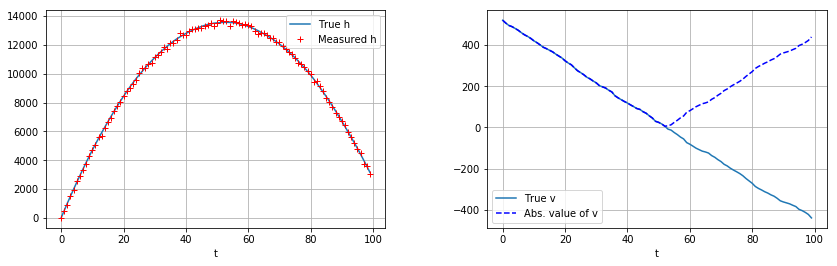

In [3]:
ndat = 100                               ### number of data
h0 = 0                                   ### initial height [m]
v0 = 520                                 ### initial velocity [m/s]
g = 9.81                                 ### grav. constant [m/s^2]
dt = 1                                   # time step in seconds
A = np.array([[1, dt], [0, 1]])          # matrix A
B = np.array([-.5*dt, -dt])              # matrix B
u = g                                    # pro forma, g=u
var_wht = 10                             ### variance of w_ht
var_wvt = 10                             ### variance of w_vt
var_y = 100**2                           ### variance of y_t

x = np.zeros((2, ndat))
x[:,0] = [h0, v0]
y = np.zeros(ndat)

for t in range(1, ndat):
    x[:,t] = A.dot(x[:,t-1]) + B.dot(u)
    x[:,t] += mvn.rvs(cov=np.diag([var_wht, var_wvt]))
    y[t] = x[0,t] + norm.rvs(scale=np.sqrt(var_y))
    
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.plot(x[0], label='True h')
plt.plot(y, '+r', label='Measured h')
plt.legend()
plt.xlabel('t')
plt.subplot(122)
plt.plot(x[1], label='True v')
plt.plot(np.abs(x[1]), '--b', label='Abs. value of v')
plt.legend()
plt.xlabel('t')
plt.show()

# State-space model

State-space model (SSM) of a system or process is characterized by three variables:
- **state** $x_t$ which is not observable, but can be estimated,
- **input** aka **control variable** $u_t$ that is known,
- **output** $y_t$ which is observable and determined by $x_t$ and $u_t$.

SSM may be either **discrete** for time instants $t=1,2,\ldots$, or **continuous** (and described by differential equations). We will stick with the discrete variant.

Generally, SSM are known (but stochastic) functions of states and inputs, which may be constant or time-varying:

$$
\begin{aligned}
x_t &= f_t(x_{t-1}, u_t), \\
y_t &= g_t(x_t).
\end{aligned}
$$

The control theory often uses an input (control) variable in the observation equation, too. However, we will disregard this case. If the system is linear - which we assumed in the motivation example above - it may be written as

>$$
\begin{aligned}
x_t &= A_t x_{t-1} + B_t u_t + w_t, \\
y_t &= H_t x_t + \varepsilon_t,
\end{aligned}
$$

where $x_t$ is the **state**, $u_t$ is the **input (control) variable**, $w_t$ and $v_t$ are the **state and measurement noise variables**, respectively, and $A_t, B_t$ and $H_t$ are compatible matrices. If the system is time-invariant, $A_t=A, B_t=B, H_t=H$.

## Markov property, Hidden Markov Models (HMM)

The state-space models are closely tight with the so-called Markov property and Markov process. The latter, also known as the first-order Markov model, is a model where the current state at time $t$ depends only on the state previous at $t-1$. That is,

$$
\begin{aligned}
&p(x_t|x_{t-1}) &\text{(transition probability)}, \\
&p(x_0) &\text{(initial state)}.
\end{aligned}
$$

The $n$th-order Markov model would have the transition probability of the form $p(x_t|x_{t-1},...,x_{t-n})$. However, the resulting calculations are much more intricate.

If the Markov process is not directly observable, but may be inferred from an observable variable (measurements) $y_t$, we talk about a **hidden Markov process**. It may be discrete or continuous in values, we assume continuity.

![HMM](img/hmm.png)

**Think abouts...**
- can you see the Markov property in SSM?
- can you see the hidden Markov model (process) in SSM?

# Kalman filter (KF)

- credit: Rudolf E. Kálmán
- similar algorithms existed earlier (Swerling, Thiele) and were developed concurrently (Bucy).
- more general filter was earlier proposed by Ruslan Stratonovich. KF is its special case.
- first application - S.F. Schmidt - space programme Apollo (navigation).
![Kalman](img/Rudolf_Kalman.jpg)

### Use: 
- Apollo (navigation)
- weapons (submarines, missiles, Tomahawk)
- navigation systems in general
- autopilots
- computer vision (https://www.youtube.com/watch?v=dKpRsdYSCLQ, https://www.youtube.com/watch?v=O4fVQKigutk)
- radar tracking
- economy models
- inertial navigation systems
- sensorless control of AC engines
- weather forecasting
- and many others, in mobile phones, cars...

## Derivation of KF

Let us for simplicity assume a time-invariant SSM

$$
\begin{aligned}
x_t &= A x_{t-1} + B u_t + w_t, \\
y_t &= H x_t + v_t,
\end{aligned}
$$

where

$$
\begin{aligned}
w_t &\sim \mathcal{N}(0, Q),\\
v_t &\sim \mathcal{N}(0, R).
\end{aligned}
$$

*In fact, normality is not necessary for KF*, but we will need it for the Bayesian filter. Moreover, it results in certain appealing optimality properties, but we will skip them. Now,

$$
\begin{aligned}
x_t &\sim \mathcal{N}(Ax_{t-1} + Bu_t, Q) &\text{s hustotou}\quad p(x_t|x_{t-1}, u_t) \\
y_t &\sim \mathcal{N}(Hx_{t}, R) &\text{s hustotou}\quad f(y_t|x_t).
\end{aligned}
$$

Since we will develop the filter (sequential estimator) of $x_t$ in the Bayesian realm, we will need a convenient prior distribution for $x_t$. Since $y_t$ is normal and with a known (co)variance, the normal distribution will be conjugate to its model. We denote its mean value $x_{t-1}^{+}$ and its covariance matrix $P_{t-1}^{+}$,

$$
\pi(x_t|y_{0:t-1}, y_{0:t-1}, u_{0:t-1}) = \mathcal{N}(x_{t-1}^{+}, P_{t-1}^{+}).
$$

The Kalman filter runs in two steps:
1. **State prediction** - it uses the first of the two SSM equations.
2. **State correction aka update** - this exploits the Bayes' theorem and the measurements $y_t$ to correct the knowledge of the predicted $x_t$.

### Prediction

$$
\pi(x_{t}|y_{0:t-1}, x_{0:t-1}, u_{0:t})
= \int p(x_{t}|x_{t-1}, u_{t}) \pi(x_{t-1}|y_{0:t-1}, x_{0:t-1}, u_{0:t-1}) dx_{t-1}.
$$

The product of two normal pdfs followed by marginalization yields another normal pdf
$\mathcal{N}(x_{t}^{-}, P_{t}^{-})$ with hyperparameters

$$
\begin{aligned}
    x_{t}^{-} &= A x_{t-1}^{+} + B u_{t}, \\
    P_{t}^{-} &= A P_{t-1}^{+} A^{\intercal} + Q.
\end{aligned}
$$

We see, that the prediction only directly uses the state evolution equation.

### Correction (update)
$$
\pi(x_{t}|y_{0:t}, x_{0:t}, u_{0:t}) 
\propto
f(y_{t}|x_{t})
\pi(x_{t}|y_{0:t-1},x_{0:t}, u_{0:t}) 
$$

Recall, that if we rewrite the model to an exponential family form, and the conjugate prior to the form compatible to it, the Bayes' theorem takes the form of summations. Hence we will do this. The model in the EF form is

$$
\begin{aligned}
    f(y_{t}|x_{t})
    &\propto \exp
        \left\{ 
            -\frac{1}{2} 
            (y_{t} - H x_{t})^{\intercal}
            R^{-1}
            (y_{t} - H x_{t})
        \right\} \\
    &= \exp
        \Bigg\{ 
            \operatorname{Tr}
            \bigg(
            \underbrace{
                -\frac{1}{2}
                \begin{bmatrix}
                    -1 \\ x_{t}
                \end{bmatrix}
                \begin{bmatrix}
                    -1 \\ x_{t}
                \end{bmatrix}^{\intercal}
            }_{\eta}
            \underbrace{
                \begin{bmatrix}
                    y_{t}^{\intercal} \\ H^{\intercal}
                \end{bmatrix}
                R^{-1}
                \begin{bmatrix}
                    y_{t}^{\intercal} \\ H^{\intercal}
                \end{bmatrix}^{\intercal}
            }_{T(y_{t})}
            \bigg)
        \Bigg\}.
\end{aligned}
$$

The compatible form of the conjugate prior is

$$
\begin{aligned}
    \pi(x_{t}|y_{0:t-1},x_{0:t}, u_{0:t}) 
    &\propto \exp
        \left\{ 
            -\frac{1}{2} 
            (x_{t} - x_{t}^{-})^{\intercal}
            (P_{t}^{-})^{-1}
            (x_{t} - x_{t}^{-})
        \right\} \notag \\
    &= \exp
        \Bigg\{
            \operatorname{Tr}
            \bigg(
            \underbrace{
                -\frac{1}{2}
                \begin{bmatrix}
                    -1 \\ x_{t}
                \end{bmatrix}
                \begin{bmatrix}
                    -1 \\ x_{t}
                \end{bmatrix}^{\intercal}
            }_{\eta}
            \underbrace{
                \begin{bmatrix}
                    (x_{t}^{-})^{\intercal} \\ I
                \end{bmatrix}
                (P_{t}^{-})^{-1}
                \begin{bmatrix}
                    (x_{t}^{-})^{\intercal} \\ I
                \end{bmatrix}^{\intercal}
            }_{\xi_{t}}
            \bigg)
        \Bigg\},
        \notag
\end{aligned}
$$
where $I$ is an identity matrix of the compatible size.

The Bayesian update is a sum

$$
\begin{aligned}
    \xi_{t} 
    &= \xi_{t-1} +  T(y_{t})  \notag \\
    &=
    \begin{bmatrix}
        (x_{t}^{-})^{\intercal} (P_{t}^{-})^{-1} x_{t}^{-} + y_{t}^{\intercal} R^{-1} y_{t}, 
            & (x_{t}^{-})^{\intercal} (P_{t}^{-})^{-1} + y_{t}^{\intercal} R^{-1} H \\
        (P_{t}^{-})^{-1} (x_{t}^{-})^{\intercal} + H^{\intercal} R^{-1} y_{t}, 
        & (P_{t}^{-})^{-1} + H^{\intercal} R^{-1} H.
    \end{bmatrix}
\end{aligned}
$$

The posterior parameters are particularly easy to derive,

$$
\begin{aligned}
    P_{t}^{+} &= (\xi_{t;[2,2]})^{-1} \\
              &= \left[ (P_{t}^{-})^{-1} + H^{\intercal} R^{-1} H \right]^{-1} \\
              &= (I - K_{t} H) P_{t}^{-} \\
    x_{t}^{+} &= (\xi_{t;[2,2]})^{-1} \xi_{t;[2,1]} \\
              &= P_{t}^{+} \left[ (P_{t}^{-})^{-1} (x_{t}^{-})^{\intercal} + H^{\intercal} R^{-1} y_{t}\right]  \\
              &= x_{t}^{-} + P_{t}^{+} H^{\intercal} R^{-1}(y_{t} - Hx_{t}^{-})
\end{aligned}
$$

where

$$
   K_{t} = P_{t}^{-} H^{\intercal}(R + H P_{t}^{-}H^{\intercal})
$$

is the Kalman gain, or more precisely, the *optimal Kalman gain*, minimizing the mean squarred error. In general, the higher gain, the bigger impact of new measurements. The filter is then more sensitive to the noise.

Remember, that there are several possible ways how to derive the (same) Kalman filter. We studied the Bayesian approach.

## In python...

Let us see the free fall example once again:

In [4]:
Q = np.diag([var_wht, var_wvt])           # This was in the simulation
R = var_y
H = np.array([1, 0])

filtr = KF(A=A, B=B, H=H, R=R, Q=Q)       # KF instance
for yt in y:
    filtr.predict(u)
    filtr.update(yt)
    filtr.log()
log_x = np.array(filtr.log_x).T

### Measurements
First let us see the raw noisy measurements.

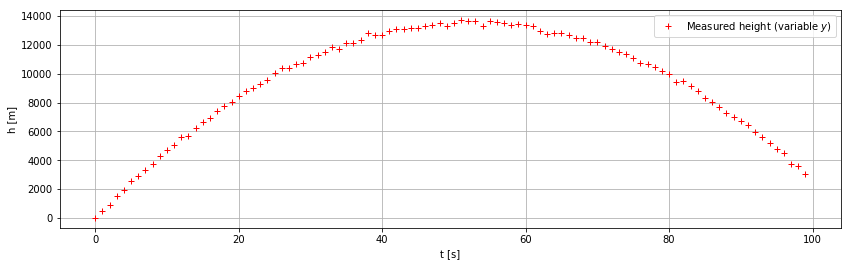

In [5]:
plt.figure(figsize=(14,4))
plt.plot(y, '+r', label=r'Measured height (variable $y$)')
plt.legend()
plt.xlabel('t [s]')
plt.ylabel('h [m]')
plt.show()

Now we add the filtered height from KF:

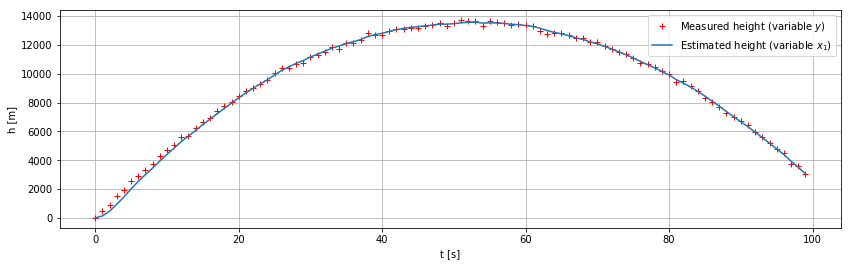

In [6]:
plt.figure(figsize=(14,4))
plt.plot(y, '+r', label=r'Measured height (variable $y$)')
plt.plot(log_x[0], label=r'Estimated height (variable $x_1$)')
plt.legend()
plt.xlabel('t [s]')
plt.ylabel('h [m]')
plt.show()

And finally we add the true height. We expect to see that the filter had to learn first, but then it is stable unless there is a high noise level ([SNR, signal-to-noise ratio](https://en.wikipedia.org/wiki/Signal-to-noise_ratio))

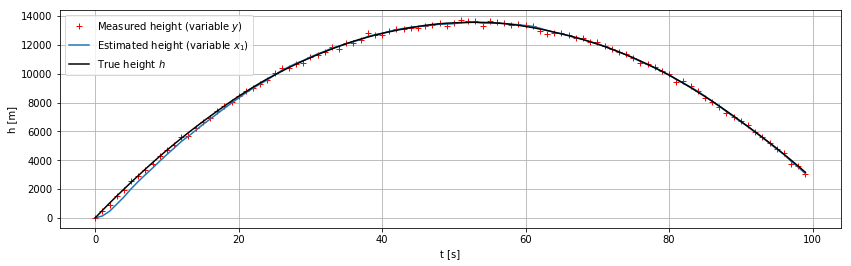

In [7]:
plt.figure(figsize=(14,4))
plt.plot(y, '+r', label=r'Measured height (variable $y$)')
plt.plot(log_x[0], label=r'Estimated height (variable $x_1$)')
plt.plot(x[0], 'k', label=r'True height $h$')
plt.legend()
plt.xlabel('t [s]')
plt.ylabel('h [m]')
plt.show()

We want to see the estimates of the velocity $v$. Again, we expect that the filter needs to learn on the first few data, but the it should be stable. **Note, that there are no measurements of the velocity, it is estimated only from the noisy measurements of the height!**

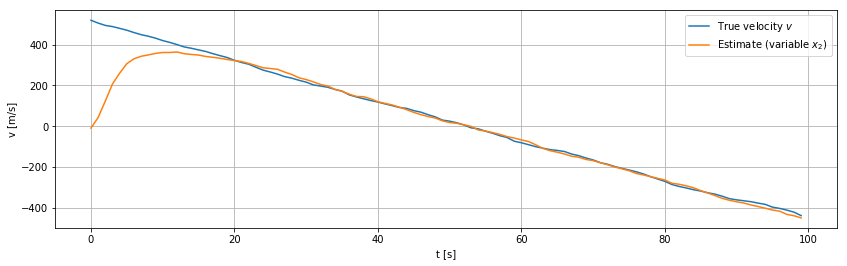

In [8]:
plt.figure(figsize=(14,4))
plt.plot(x[1], label=r'True velocity $v$')
plt.plot(log_x[1], label=r'Estimate (variable $x_2$)')
plt.xlabel('t [s]')
plt.ylabel('v [m/s]')
plt.legend()
plt.show()

# Nonlinear SSM

Nonlinear state-space models also have the form

$$
\begin{aligned}
x_t &= f_t(x_{t-1}, u_t), \\
y_t &= g_t(x_t),
\end{aligned}
$$

however, either one or both functions are nonlinear. There are several possible solutions:

1. Under mild nonlinearity, it is possible to use local linearizations with first or second-order derivatives. This yields the popular [extended Kalman filter, EKF](https://en.wikipedia.org/wiki/Extended_Kalman_filter). Although it is not optimal and may potentially diverge, it is a standard filter in GPS navigation.
2. Under less severe nonlinearities, the [unscented Kalman filter (UKF)](https://en.wikipedia.org/wiki/Kalman_filter#Unscented_Kalman_filter) provides a solution.
3. In any case, it is possible to use "brute-force" Monte Carlo methods. They sample many candidate states from the corresponding state space and choose or assign them with weights according to their likelihood. A very popular example is the [particle filter](https://en.wikipedia.org/wiki/Particle_filter). We will talk about it later.